<a href="https://colab.research.google.com/github/akaanirban/a-dnn-every-week/blob/main/NLP/SeqTOSeq/Dabble_with_Attentions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Some dabble with attention. Mostly following and modifying code from this [FloydHub post](https://blog.floydhub.com/attention-mechanism/) and [this](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html). 
While attentions is used in both CV and NLP equally extensively, this one is on sequence to sequence model. An upgrade to the [other simpler notebook](./Simple_Seq_to_Seq_nmt.ipynb) if you will.

TODO: 

1. Rewite overall text to be more recap friendly. 
2. Figure out why the attention plot gives garbage values. Probably indexing error.

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
# ! wget http://www.manythings.org/anki/ben-eng.zip
# ! unzip ben-eng.zip

In [3]:
! head ben.txt

Go.	যাও।	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5545004 (tanay)
Go.	যান।	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5545005 (tanay)
Go.	যা।	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5545006 (tanay)
Run!	পালাও!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5548781 (tanay)
Run!	পালান!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5548783 (tanay)
Who?	কে?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #5548787 (tanay)
Fire!	আগুন!	CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #3232240 (tanay)
Help!	বাঁচাও!	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #5548780 (tanay)
Help!	বাঁচান!	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #5548782 (tanay)
Stop!	থামুন!	CC-BY 2.0 (France) Attribution: tatoeba.org #448320 (CM) & #5545000 (tanay)


In [4]:
# import nltk 
# nltk.download('stopwords')
# STOPWORDS_ENG = nltk.corpus.stopwords.words('english')
# STOPWORDS_BENG = nltk.corpus.stopwords.words('bengali')
PUNCTUATIONS = [ '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',"'",",",'~' , '—']
punct_regex_expression = "[!\"#$%&()*+-.\/\\:;<=>?@[\]^_`{|}\\t\\n\',~—]"

In [5]:
lines= pd.read_table('ben.txt', names=['ben', 'eng'])
lines.reset_index(inplace=True)
lines.head()

,index,ben,eng
0,Go.,যাও।,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,যান।,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,যা।,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Run!,পালাও!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Run!,পালান!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [6]:
lines.columns = ["eng", "ben", "info"]
lines.drop(['info'], axis=1, inplace=True)
lines.head()

,eng,ben
0,Go.,যাও।
1,Go.,যান।
2,Go.,যা।
3,Run!,পালাও!
4,Run!,পালান!


In [7]:
# Remove Punctuations
lines = lines[lines.notna()]
transtable = str.maketrans(dict.fromkeys("".join(PUNCTUATIONS), ''))
numbers = str.maketrans(dict.fromkeys("0123456789০১২৩৪৫৬৭৮৯", ""))
lines['eng'] = (lines['eng'].str.lower()
                        .str.translate(transtable)
                        .str.translate(numbers)
                        .str.strip())
lines['ben'] = (lines['ben'].str.lower()
                        .str.translate(transtable)
                        .str.translate(numbers)
                        .str.strip())

In [8]:
# # Add start and end tokens to target sequences
# lines.ben = lines.ben.apply(lambda x : 'START_ '+ x + ' _END')

In [9]:
lines.sample(10)

,eng,ben
3029,theres nothing i can do,আমার কিছু করার নেই।
3739,show me a cheaper one please,আমাকে আরো সস্তা একটা দেখান।
2596,what are you here for,আপনি এখানে কি জন্যে এসেছেন
2999,i lost your phone number,আমি তোমার ফোন নাম্বারটা হারিয়ে ফেলেছি।
2715,is tom still mad at me,টম কি এখনো আমার উপর রেগে আছে
3864,tom tried to keep from smiling,টম না হাসার চেষ্টা করছিলেন।
38,try it,চেখে দেখুন।
27,i know,আমার জানা আছে।
868,who sent you,আপনাকে কে পাঠিয়েছে
2157,im eating rice now,আমি এখন ভাত খাচ্ছি।


In [10]:
lines = lines.reset_index(drop=True)

In [11]:
# english and bengali vocab in the dataset 
eng_words = set(['_SOS','_EOS','_UNK'] + [i for j in lines.eng for i in j.split()])
ben_words = set(['_SOS','_EOS','_UNK'] + [i for j in lines.ben for i in j.split()])

# max source and target sequence
eng_max = max([len(i.split()) for i in lines.eng])
ben_max = max([len(j.split()) for j in lines.ben])
print(eng_max, ben_max)

input_words = sorted(list(eng_words))
target_words = sorted(list(ben_words))
num_encoder_tokens = len(eng_words)
num_decoder_tokens = len(ben_words)
num_encoder_tokens, num_decoder_tokens

19 18


(1887, 3395)

In [12]:
# string to index and index to string 
input_token_index = dict([(word, i) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i) for i, word in enumerate(target_words)])
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [13]:
lines = shuffle(lines)
lines.head(10)

,eng,ben
8,help,বাঁচান
873,you are rich,আপনি ধনী।
2831,how much does this cost,এর দাম কত
4030,london is the capital of england,লন্ডন ইংল্যান্ডের রাজধানি।
809,let me speak,আমাকে কথা বলতে দাও।
3626,i didnt want this to happen,আমি চাইনি এটা ঘটুক।
186,im back,আমি ফিরে এসেছি।
3232,are you a japanese citizen,আপনি কি জাপানী নাগরিক
1434,puzzles are fun,ধাঁধা মজার জিনিস।
3333,whats the meaning of that,ওটার অর্থ কী


In [14]:
# Train - Test Split
X, y = lines.eng, lines.ben
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
print(X_train.shape, X_test.shape)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

(4173,) (464,)


In [15]:
X_train[0:10], y_train[0:10]

(0                       it was entirely toms fault
 1                                i have two nieces
 2    i feed my cat every morning and every evening
 3                        she got sick this weekend
 4                                       follow tom
 5                           toms mother was crying
 6                      i understand your situation
 7                                            smile
 8                                who wants to know
 9                                     its not mine
 Name: eng, dtype: object,
 0                        এটা পুরোপুরিই টমের দোষ ছিলো।
 1                               আমার দুটো ভাগ্নী আছে।
 2    আমি আমার বেড়ালকে রোজ সকালে আর বিকালে খাবার দিই।
 3       গত সপ্তাহের শেষের দিকে ও অসুস্থ হয়ে পরেছিলো।
 4                                 টমের পেছন পেছন যাও।
 5                                  টমের মা কাঁদছিলেন।
 6                     আমি তোমার অবস্থাটা বুঝতে পারছি।
 7                                         একটু হাসুন।
 8           

### As I understand and I may be wrong factually, attention gives the network ability to focus on certain parts. If the certain parts quantify the interdependece between the inputs then it is Self Attention, otherwise if the interdependence is between the input and the output then it is general Attention. 

So for example, in case of self attention between two sentences, the keys and queries, the output of the attention for each word is essentially a probability distribution over all the words of the entire sentence. The peak of this distribution happens at the word which is the most relevant to the current word in this sentence. 

Suppose we have an English Sentence "I hate going to school." and a corresponding Bengali sentence "আমি স্কুলে যাওয়া পছন্দ করি না" In case of NMT, the way Attentions works is that for each word of the output Bengali sentence it will find the prob distribution per se on the input English sentence such that the most relevant words to the current Bengali word, receive higher weights. 

Mostly in NLP attention became largely prevalent because they originally helped do away with the problem with large sequences in seq-to-seq models. As you have seen in the Simpler notebooks, the larger the sentences become, the mode ridiculous the translations were. Since the last hidden layer/state of the LSTM/GRU encoder is used as the context vector of the decoder, is a sentence is long, it fails to encode the entire useful information. Attention though has access to entire input sequence and can circumvent this problem. Moreover RNNS are very expensive computationally, hence training them is resource intensive (definitely a concern while training them on edge devices), while Attentions mechanisms are generally much more resource friendly. 

The following are two main types:

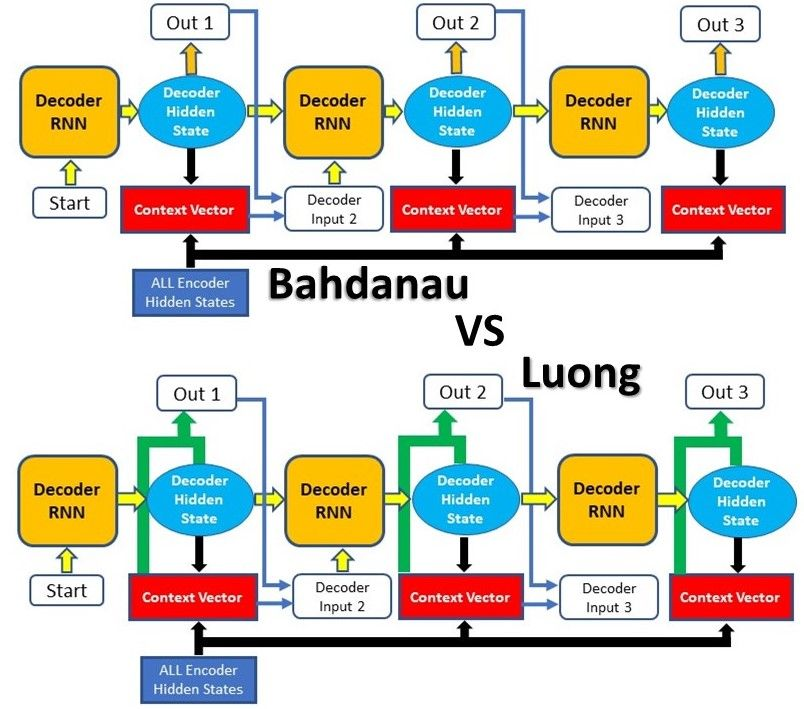

In [16]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [17]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers =1, dropout_prob=0):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.n_layers = n_layers
        self.dropout_prob = dropout_prob
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers, dropout=dropout_prob, batch_first=True)

    def forward(self, inputs, hidden):
        embedded = self.embedding(inputs)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def init_hidden(self, batch_size=1):
        # in general all the weights are initialized to zero
        global DEVICE
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=DEVICE),
                torch.zeros(self.n_layers, batch_size, self.hidden_size, device=DEVICE))

## Bahdanau Decoder

In [18]:
class BahdanauDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_prob=0):
        super(BahdanauDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_prob = dropout_prob

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.fc_decoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.fc_encoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.weight = nn.Parameter(torch.FloatTensor(1, self.hidden_size))
        self.classifier = nn.Linear(self.hidden_size, self.output_size)
        self.dropout = nn.Dropout(self.dropout_prob)
        self.lstm = nn.LSTM(2*self.hidden_size, self.hidden_size, num_layers=self.n_layers, batch_first=True)

    def forward(self, inputs, encoder_output, decoder_hidden, decoder_cell_state):
        encoder_output = encoder_output.squeeze()
        #Embed input words
        embedded = self.embedding(inputs).view(1, -1)
        embedded = self.dropout(embedded)
        # Calculate the alignment score
        decoder_intermediate = self.fc_decoder(decoder_hidden)
        encoder_intermediate = self.fc_encoder(encoder_output)
        tanh = torch.tanh(decoder_intermediate + encoder_intermediate) # 1x4x256
        alignment_scores = tanh.bmm(self.weight.unsqueeze(2)) # 1x4x256 . 1x256x1
        ##### Calculate attention using softmax
        attention_weights = F.softmax(alignment_scores.view(1, -1), dim=1) #1x4x1
        #####
        context_vector = torch.bmm(attention_weights.unsqueeze(0), encoder_output.unsqueeze(0)) # unsqueeze for batch dimension
        #### concat the context vector with the embedded nput word
        final_input_to_decoder = torch.cat([embedded, context_vector.squeeze(0)], 1).unsqueeze(0) #1x1x512 # again squeeze unsqueeze to take care of batch dimension
        output, hidden = self.lstm(final_input_to_decoder, [decoder_hidden, decoder_cell_state])
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        return output, hidden, attention_weights

class LuongDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, attention, n_layers=1, drop_prob=0.1):
        super(LuongDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob

        #Our Attention Mechanism is defined in a separate class
        self.attention = attention

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.classifier = nn.Linear(self.hidden_size*2, self.output_size)
    
    def forward(self, inputs, hidden, encoder_outputs):
        #Embed input words
        embedded = self.embedding(inputs).view(1,1,-1)
        embedded = self.dropout(embedded)

        #Passing previous output word (embedded) and hidden state into LSTM cell
        lstm_out, hidden = self.lstm(embedded, hidden)

        #Calculating Alignment Scores - see Attention class for the forward pass function
        alignment_scores = self.attention(hidden[0], encoder_outputs)
        #Softmaxing alignment scores to obtain Attention weights
        attn_weights = F.softmax(alignment_scores.view(1,-1), dim=1)

        #Multiplying Attention weights with encoder outputs to get context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs)

        #Concatenating output from LSTM with context vector
        output = torch.cat((lstm_out, context_vector),-1)
        #Pass concatenated vector through Linear layer acting as a Classifier
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        return output, hidden, attn_weights

class Attention(nn.Module):
    def __init__(self, hidden_size, method="dot"):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

        #Defining the layers/weights required depending on alignment scoring method
        if method == "general":
            self.fc = nn.Linear(hidden_size, hidden_size, bias=False)

        elif method == "concat":
            self.fc = nn.Linear(hidden_size, hidden_size, bias=False)
            self.weight = nn.Parameter(torch.FloatTensor(1, hidden_size))
  
    def forward(self, decoder_hidden, encoder_outputs):
        if self.method == "dot":
          #For the dot scoring method, no weights or linear layers are involved
          return encoder_outputs.bmm(decoder_hidden.view(1,-1,1)).squeeze(-1)
    
        elif self.method == "general":
            #For general scoring, decoder hidden state is passed through linear layers to introduce a weight matrix
            out = self.fc(decoder_hidden)
            return encoder_outputs.bmm(out.view(1,-1,1)).squeeze(-1)

        elif self.method == "concat":
            #For concat scoring, decoder hidden state and encoder outputs are concatenated first
            out = torch.tanh(self.fc(decoder_hidden+encoder_outputs))
            return out.bmm(self.weight.unsqueeze(-1)).squeeze(-1)

In [19]:
hidden_size = 256
encoder = EncoderLSTM(len(input_token_index), hidden_size).to(DEVICE)
decoder = BahdanauDecoder(hidden_size,len(target_token_index)).to(DEVICE)

lr = 0.001
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

### Similar to the blog, we will use teacher forcing. We will use teacher forcing for 50% of the inputs, where we will use the real target values from the dataset as inputs to the next step of the decider. For the rest, we will use the output of the last hidden layer as the input to the next step. We do this to make the model converge faster. This may result in some instability and ofcourse overfitting. But this is a POC. So what the hell. 

In [20]:
from tqdm.notebook import tqdm
import random
random.seed(42)

In [21]:
EPOCHS = 10
teacher_forcing_prob = 0.0
encoder.train()
decoder.train()
tk = tqdm(range(1+EPOCHS), total=EPOCHS)

for epochs in tk:
    average_loss = 0
    tk1 = tqdm(enumerate(X_train), total=len(X_train), leave=False)
    for i, review in tk1:
        loss = 0
        review = review.split() + ["_EOS"]
        review = [input_token_index[word] for word in review]
        h = encoder.init_hidden()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        input = torch.tensor(review).unsqueeze(0).to(DEVICE)
        encoder_outputs, h = encoder(input, h)

        # First decoder input token will be the Start of Sentence token
        decoder_input = torch.tensor([input_token_index["_SOS"]], device=DEVICE)
        # First decoder hidden state will be the last encoder hidden state
        decoder_hidden, decoder_cell_state = h
        output = []
        teacher_forcing = random.random() < teacher_forcing_prob
        
        sentence = y_train[i].split() + ["_EOS"]
        # iterate over all the tokens of the target bengali sentence
        for index in range(len(sentence)):
            decoder_output, (decoder_hidden,decoder_cell_state), attention_wts = decoder(decoder_input, encoder_outputs, decoder_hidden, decoder_cell_state)
            # Get the index value of the word with the highest score from the decoder output
            top_value, top_index = decoder_output.topk(1)
            if True:
                # The embedding layer takes as input the index of the element in the embedding you want to select and return the corresponding embedding. The input is expected to be a LongTensor because it is an index and so must be an integer. 
                decoder_input = torch.tensor([target_token_index[sentence[index]]], device=DEVICE)
            else:
                decoder_input = torch.tensor([top_index.item()], device=DEVICE)
            output.append(top_index.item())
            # loss against actual word
            loss += F.nll_loss(decoder_output.view(1, -1), torch.tensor([target_token_index[sentence[index]]], device=DEVICE))
        loss = loss/len(sentence)
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        average_loss+=loss.item()/len(y_train)
        #if i%2000==0:
        #    print(average_loss, decoder_output.view(1, -1), torch.tensor([target_token_index[sentence[index]]], device=DEVICE))
    tk.set_postfix(loss=average_loss)
    #Save model after every epoch (Optional)
    torch.save({"encoder":encoder.state_dict(),"decoder":decoder.state_dict(),"e_optimizer":encoder_optimizer.state_dict(),"d_optimizer":decoder_optimizer},"./model.pt")


In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
encoder.eval()
decoder.eval()
#Choose a random sentences
for _ in range(10):
    i = random.randint(0,len(X_train)-1)
    h = encoder.init_hidden()
    review = X_train[i].split() + ["_EOS"]
    review = [input_token_index[word] for word in review]
    inp = torch.tensor(review).unsqueeze(0).to(DEVICE)
    encoder_outputs, h = encoder(inp,h)

    # First decoder input token will be the Start of Sentence token
    decoder_input = torch.tensor([input_token_index["_SOS"]], device=DEVICE)
    # First decoder hidden state will be the last encoder hidden state
    decoder_hidden, decoder_cell_state = h
    output = []
    attentions = []
    sentence = y_train[i].split() + ["_EOS"]

    while True:
        decoder_output, (decoder_hidden,decoder_cell_state), attention_wts = decoder(decoder_input, encoder_outputs, decoder_hidden, decoder_cell_state)
        _, top_index = decoder_output.topk(1)
        decoder_input = torch.tensor([top_index.item()],device=DEVICE)
        #If the decoder output is the End Of Sentence token, stop decoding process
        if top_index.item() == target_token_index["_EOS"]:
            break
        output.append(top_index.item())
        attentions.append(attention_wts.squeeze().cpu().detach().numpy())
    print(f"English: {X_train[i]}")
    print("Predicted: " + " ".join([reverse_target_char_index[x] for x in output]))
    print(f"Actual: {y_train[i]}")
    print("-"*80)

# #Plotting the heatmap for the Attention weights
# fig = plt.figure(figsize=(12,9))
# ax = fig.add_subplot(111)
# cax = ax.matshow(np.array(attentions))
# fig.colorbar(cax)
# ax.set_xticklabels(X_train[i].split())
# ax.set_yticklabels(y_train[i].split())
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# plt.show()

English: they dont care
Predicted: তারা পরোয়া করে না।
Actual: তারা পরোয়া করে না।
--------------------------------------------------------------------------------
English: the servants screams awakened everyone
Predicted: চাকরগুলোর চিৎকার সবাইকে জাগিয়ে দিলো।
Actual: চাকরগুলোর চিৎকার সবাইকে জাগিয়ে দিলো।
--------------------------------------------------------------------------------
English: wheres the ticket counter
Predicted: টিকিট কাউন্টারটা কোথায়
Actual: টিকিট কাউন্টারটা কোথায়
--------------------------------------------------------------------------------
English: lets try to make tom laugh
Predicted: টমকে হাসানোর চেষ্টা করা যাক।
Actual: টমকে হাসানোর চেষ্টা করা যাক।
--------------------------------------------------------------------------------
English: i donated blood this afternoon
Predicted: আমি আজ দুপুরে রক্তদান করলাম।
Actual: আমি আজ দুপুরে রক্তদান করলাম।
--------------------------------------------------------------------------------
English: how long have you been livin

### Clearly we have overfitted. But the networks learns.


### Lets try on the unseen dataset

In [35]:

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
encoder.eval()
decoder.eval()
#Choose a random sentences
for _ in range(10):
    i = random.randint(0,len(X_test)-1)
    h = encoder.init_hidden()
    review = X_test[i].split() + ["_EOS"]
    review = [input_token_index[word] for word in review]
    inp = torch.tensor(review).unsqueeze(0).to(DEVICE)
    encoder_outputs, h = encoder(inp,h)

    # First decoder input token will be the Start of Sentence token
    decoder_input = torch.tensor([input_token_index["_SOS"]], device=DEVICE)
    # First decoder hidden state will be the last encoder hidden state
    decoder_hidden, decoder_cell_state = h
    output = []
    attentions = []
    sentence = y_test[i].split() + ["_EOS"]

    while True:
        decoder_output, (decoder_hidden,decoder_cell_state), attention_wts = decoder(decoder_input, encoder_outputs, decoder_hidden, decoder_cell_state)
        _, top_index = decoder_output.topk(1)
        decoder_input = torch.tensor([top_index.item()],device=DEVICE)
        #If the decoder output is the End Of Sentence token, stop decoding process
        if top_index.item() == target_token_index["_EOS"]:
            break
        output.append(top_index.item())
        attentions.append(attention_wts.squeeze().cpu().detach().numpy())
    print(f"English: {X_test[i]}")
    print("Predicted: " + " ".join([reverse_target_char_index[x] for x in output]))
    print(f"Actual: {y_test[i]}")
    print("-"*80)

# #Plotting the heatmap for the Attention weights
# fig = plt.figure(figsize=(12,9))
# ax = fig.add_subplot(111)
# cax = ax.matshow(np.array(attentions))
# fig.colorbar(cax)
# ax.set_xticklabels(X_train[i].split())
# ax.set_yticklabels(y_train[i].split())
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# plt.show()

English: were you born there
Predicted: আপনি কি ওখানে জন্মেছিলেন
Actual: তুমি কি ওখানে জন্মেছিলে
--------------------------------------------------------------------------------
English: tom slept outside
Predicted: টম বাইরে ছিলো।
Actual: টম বাইরে ঘুমালো।
--------------------------------------------------------------------------------
English: the baby is screaming
Predicted: টম চেঁচাচ্ছে।
Actual: বাচ্চাটা চিৎকার করছে।
--------------------------------------------------------------------------------
English: go home
Predicted: বাড়ি যান।
Actual: বাড়ি যা।
--------------------------------------------------------------------------------
English: tom went outside
Predicted: বাইরে বাইরে অপেক্ষা করলো।
Actual: টম বাইরে গেলো।
--------------------------------------------------------------------------------
English: tom used to be scared of dogs
Predicted: টম কুকুরকে ভয় পেতো।
Actual: টমের কুকুরের প্রতি ভয় ছিলো।
--------------------------------------------------------------------------------
En

In [36]:
attentions

[array([0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32)]

---

## Using Luong Attention
Unlike in Bahdanau Attention, the decoder in Luong Attention uses the RNN in the first step of the decoding process rather than the last.

In [39]:
hidden_size = 256
encoder = EncoderLSTM(len(input_token_index), hidden_size).to(DEVICE)
attn = Attention(hidden_size,"concat")
decoder = LuongDecoder(hidden_size,len(target_token_index), attention=attn).to(DEVICE)

lr = 0.001
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

In [40]:
EPOCHS = 10
teacher_forcing_prob = 0.0
encoder.train()
decoder.train()
tk = tqdm(range(1+EPOCHS), total=EPOCHS)

for epochs in tk:
    average_loss = 0
    tk1 = tqdm(enumerate(X_train), total=len(X_train), leave=False)
    for i, review in tk1:
        loss = 0
        review = review.split() + ["_EOS"]
        review = [input_token_index[word] for word in review]
        h = encoder.init_hidden()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        input = torch.tensor(review).unsqueeze(0).to(DEVICE)
        encoder_outputs, h = encoder(input, h)

        # First decoder input token will be the Start of Sentence token
        decoder_input = torch.tensor([input_token_index["_SOS"]], device=DEVICE)
        # First decoder hidden state will be the last encoder hidden state
        decoder_hidden, decoder_cell_state = h
        output = []
        teacher_forcing = random.random() < teacher_forcing_prob
        
        sentence = y_train[i].split() + ["_EOS"]
        # iterate over all the tokens of the target bengali sentence
        for index in range(len(sentence)):
            decoder_output, (decoder_hidden,decoder_cell_state), attention_wts = decoder(decoder_input, [decoder_hidden, decoder_cell_state], encoder_outputs)
            # Get the index value of the word with the highest score from the decoder output
            top_value, top_index = decoder_output.topk(1)
            if True:
                # The embedding layer takes as input the index of the element in the embedding you want to select and return the corresponding embedding. The input is expected to be a LongTensor because it is an index and so must be an integer. 
                decoder_input = torch.tensor([target_token_index[sentence[index]]], device=DEVICE)
            else:
                decoder_input = torch.tensor([top_index.item()], device=DEVICE)
            output.append(top_index.item())
            # loss against actual word
            loss += F.nll_loss(decoder_output.view(1, -1), torch.tensor([target_token_index[sentence[index]]], device=DEVICE))
        loss = loss/len(sentence)
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        average_loss+=loss.item()/len(y_train)
        #if i%2000==0:
        #    print(average_loss, decoder_output.view(1, -1), torch.tensor([target_token_index[sentence[index]]], device=DEVICE))
    tk.set_postfix(loss=average_loss)
    #Save model after every epoch (Optional)
    torch.save({"encoder_luong":encoder.state_dict(),"decoder_luong":decoder.state_dict(),"e_optimizer_luong":encoder_optimizer.state_dict(),"d_optimizer_luong":decoder_optimizer},"./model_luong.pt")


### Run the NMT on test dataset

In [44]:

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
encoder.eval()
decoder.eval()
#Choose a random sentences
for _ in range(10):
    i = random.randint(0,len(X_test)-1)
    h = encoder.init_hidden()
    review = X_test[i].split() + ["_EOS"]
    review = [input_token_index[word] for word in review]
    inp = torch.tensor(review).unsqueeze(0).to(DEVICE)
    encoder_outputs, h = encoder(inp,h)

    # First decoder input token will be the Start of Sentence token
    decoder_input = torch.tensor([input_token_index["_SOS"]], device=DEVICE)
    # First decoder hidden state will be the last encoder hidden state
    decoder_hidden, decoder_cell_state = h
    output = []
    attentions = []
    sentence = y_test[i].split() + ["_EOS"]

    while True:
        decoder_output, (decoder_hidden,decoder_cell_state), attention_wts = decoder(decoder_input, [decoder_hidden, decoder_cell_state], encoder_outputs)
        _, top_index = decoder_output.topk(1)
        decoder_input = torch.tensor([top_index.item()],device=DEVICE)
        #If the decoder output is the End Of Sentence token, stop decoding process
        if top_index.item() == target_token_index["_EOS"]:
            break
        output.append(top_index.item())
        attentions.append(attention_wts.squeeze().cpu().detach().numpy())
    print(f"English: {X_test[i]}")
    print("Predicted: " + " ".join([reverse_target_char_index[x] for x in output]))
    print(f"Actual: {y_test[i]}")
    print("-"*80)

#Plotting the heatmap for the Attention weights
# fig = plt.figure(figsize=(12,9))
# ax = fig.add_subplot(111)
# cax = ax.matshow(np.array(attentions))
# fig.colorbar(cax)
# ax.set_xticklabels(X_test[i].split())
# ax.set_yticklabels(y_test[i].split())
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# plt.show()

English: then what
Predicted: তাহলে
Actual: তাহলে আবার কী
--------------------------------------------------------------------------------
English: who wants to see me
Predicted: কে আমার সাথে কথা বলতে চায়
Actual: কে আমাকে দেখতে চায়
--------------------------------------------------------------------------------
English: wait here till i come back
Predicted: আমি আসা পর্যন্ত এখানে অপেক্ষা করবেন।
Actual: আমি আসা পর্যন্ত এখানে অপেক্ষা কোরো।
--------------------------------------------------------------------------------
English: well never be able to play any better
Predicted: আমাদের কাছে কোনো সাহায্য করতে হবে না।
Actual: আমরা কখনই এর থেকে ভালো খেলতে পারবো না।
--------------------------------------------------------------------------------
English: youre screaming
Predicted: আপনারা চিৎকার করছেন।
Actual: আপনি চিৎকার করছেন।
--------------------------------------------------------------------------------
English: he can read
Predicted: ও পড়তে পারে।
Actual: সে পড়তে পারে।
------------------

### The Luong Attention seems to work much better on unseen data. 